## Introduction

This project demonstrates how to implement and analyze linear regression models using a real-world dataset: **medical insurance charges**. We aim to predict a person's medical expenses (`charges`) based on demographic and health-related features (e.g., `age`, `bmi`, `smoker`, etc.).

## Key Definitions

- **Linear Regression**: A method for modeling the relationship between a scalar response and one or more explanatory variables by fitting a linear equation.

- **Gradient Descent**: An optimization algorithm that iteratively adjusts weights to minimize a cost function, especially useful when direct matrix inversion is infeasible.

- **Residuals**: The difference between actual and predicted values. Analyzing residuals helps detect patterns the model fails to capture.


We will implement:
- A closed-form solution using the normal equation,
- An iterative solution via gradient descent,
- scikit-learn’s `LinearRegression` as a baseline,
and compare their predictions, performance, and residuals.

Dataset: [`insurance.csv`](./insurance.csv) with 1338 entries and 7 features including:
- `age`, `sex`, `bmi`, `children`, `smoker`, `region`, and `charges`.

We will:
1. Explore and visualize the data
2. Normalize features
3. Train and evaluate models
4. Analyze residuals and coefficients

In [31]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_theme()

df  = pd.read_csv("../Datasets/insurance.csv")

## Step 1: Exploratory Data Analysis

We explore the marginal distributions of key features (`age`, `bmi`, `children`, `charges`) using histograms.

Then, we examine feature correlations through a heatmap. Categorical variables like `sex`, `smoker`, and `region` are one-hot encoded to include them in the correlation matrix.

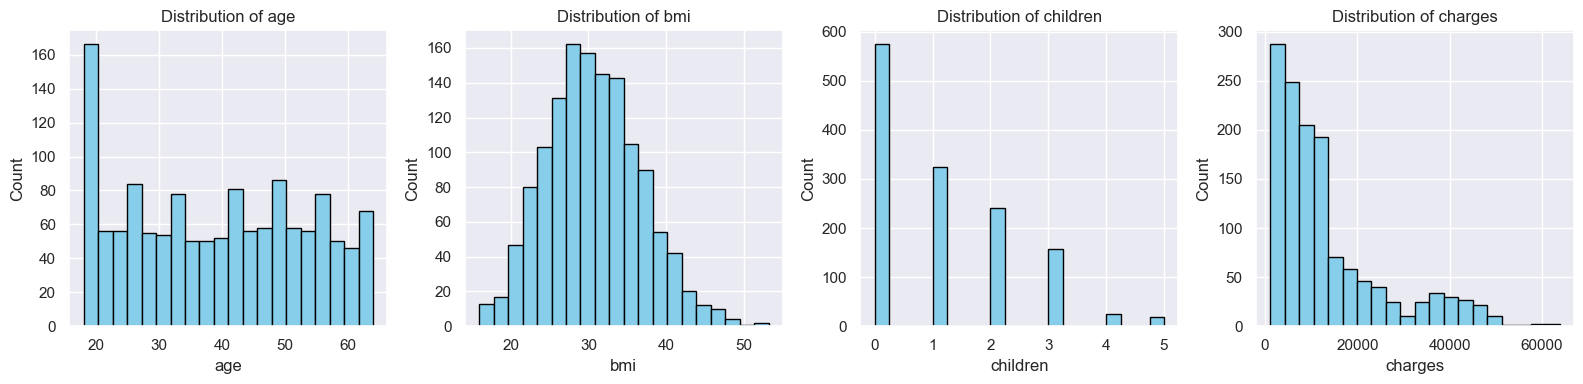

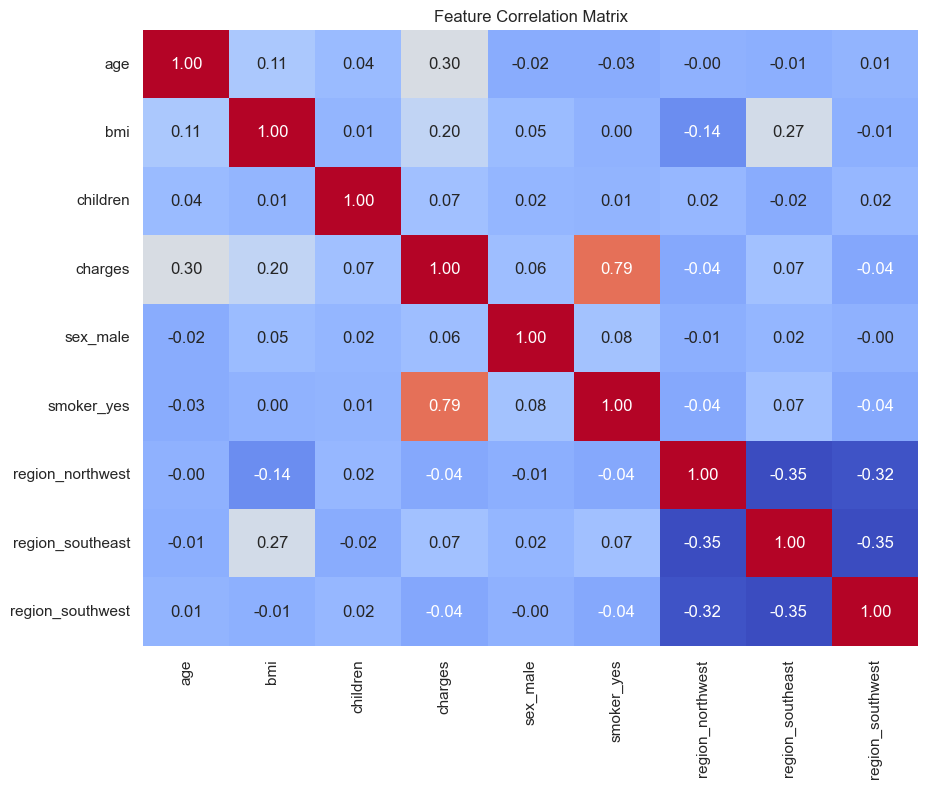

In [32]:
# Initial histograms
plt.figure(figsize=(16,4))
for i, col in enumerate(['age','bmi','children','charges']):
    ax = plt.subplot(1,4,i+1)
    df[col].hist(bins=20, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap
df_enc = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
plt.figure(figsize=(10,8))
sns.heatmap(df_enc.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title('Feature Correlation Matrix')
plt.show()

### Analysis of Feature Distributions and Correlations

- `age`: Uniformly distributed with a slight skew toward younger individuals.
- `bmi`: Normally distributed with a long right tail — potential outliers.
- `children`: Discrete and right-skewed, with most entries between 0–2 children.
- `charges`: Heavily right-skewed; most people pay lower charges but some pay significantly more, indicating potential for heteroscedasticity.

#### Correlation Heatmap Insights

- `smoker_yes` has the **strongest positive correlation** with `charges` — supporting the medical hypothesis that smokers have higher medical costs.
- `bmi` and `age` also correlate moderately with `charges`.
- `sex`, `region`, and `children` show little to no direct correlation.


## Step 2: Visualizing Key Feature Interactions

To understand interactions, we plot `charges` versus `bmi`, grouped by `smoker` status. The regression lines show that **smokers incur significantly higher costs at the same BMI**, emphasizing the impact of this binary feature.


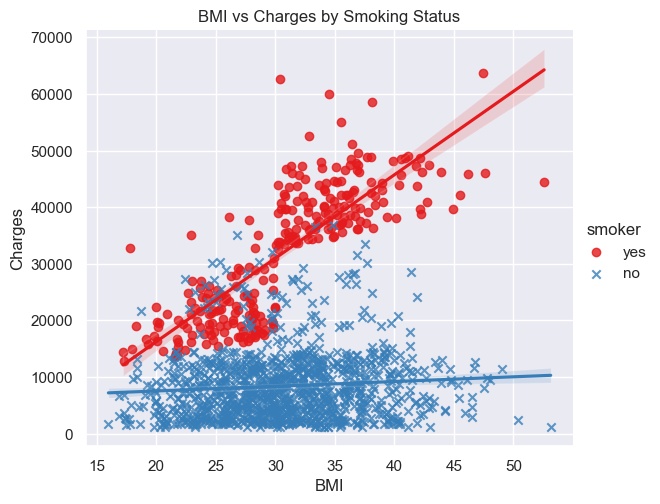

In [33]:
sns.lmplot(x='bmi', y='charges', hue='smoker', data=df,
           markers=['o','x'], palette='Set1', height=5, aspect=1.2)
plt.title('BMI vs Charges by Smoking Status')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

### Analysis of BMI vs. Charges by Smoker Status

- Two clear regression lines separate smokers and non-smokers.
- For the same BMI, smokers incur **much higher charges**, suggesting a **large intercept shift** due to smoking status.
- There's a visible interaction between `bmi` and `smoker` — indicating that feature combinations may improve model accuracy.


## Step 3:  One-Hot Encoding, Standardization, and Splitting

We begin by loading the **medical cost dataset** (`insurance.csv`) into a pandas DataFrame.

This dataset contains 1,338 rows and includes features such as:
- `age`, `sex`, `bmi`, `children`, `smoker`, `region`, and
- `charges` (our target variable).

Instead of displaying the raw data directly, we proceed to **encode categorical variables** and **split the data**.

### Preprocessing Steps:
1. **One-Hot Encoding**:  
   Categorical columns (`sex`, `smoker`, and `region`) are transformed into binary indicator variables using `pd.get_dummies()` with `drop_first=True`.  
   This avoids multicollinearity by removing one category per variable.

2. **Train-Test Split**:  
   - `X`: all features (excluding `charges`)
   - `y`: the target `charges`  
   We split the dataset using an 80/20 ratio with `random_state=0` to ensure reproducibility.

3. **Standardization**:  
   Only numerical columns (`age`, `bmi`, `children`) are standardized using **z-score normalization**:

   \[
   x_{\text{scaled}} = \frac{x - \mu}{\sigma}
   \]

   This ensures that gradient descent converges efficiently and that all features contribute comparably to the model.

We also append a column of 1s to our feature matrix to account for the bias term in linear regression.

In [34]:

# 1) One-hot encode
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)

# 2) Split
x_label = df.drop('charges', axis=1)
X = df.drop('charges',axis=1).values
y = df['charges'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# 3) Standardize
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 4) Add bias column
X_train_b = np.c_[np.ones((X_train_std.shape[0],1)), X_train_std]
X_test_b  = np.c_[np.ones((X_test_std.shape[0],1)),  X_test_std]

## Step 4: Closed-Form Linear Regression

We compute the optimal weight vector $\mathbf{w}$ using the normal equation:

$$
\mathbf{w} = (X^TX)^{-1}X^Ty
$$


This method directly minimizes the Mean Squared Error (MSE), but requires matrix inversion which can be costly for large datasets.


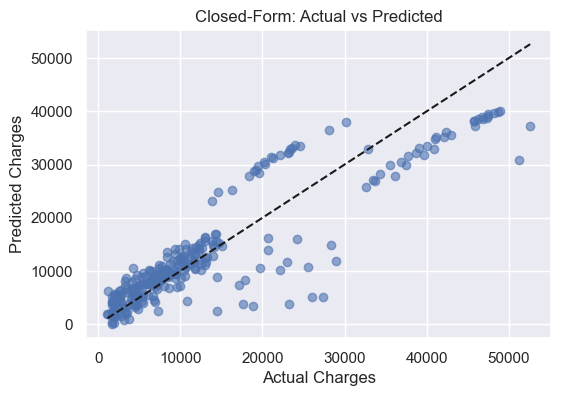

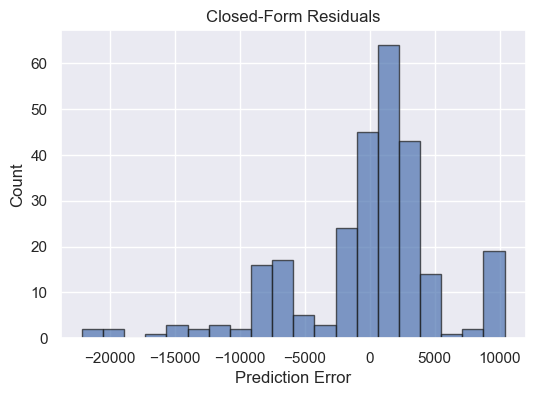

In [35]:

## Model 1: Closed-Form (Normal Equation)
# w = (X^T X)^{-1} X^T y
w_closed     = np.linalg.inv(X_train_b.T @ X_train_b) @ (X_train_b.T @ y_train)
y_pred_closed = X_test_b @ w_closed

# 2. CLOSED-FORM VISUALIZATIONS
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_closed, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Closed-Form: Actual vs Predicted")
plt.show()

# Residuals
res_closed = y_pred_closed.flatten() - y_test.flatten()
plt.figure(figsize=(6,4))
plt.hist(res_closed, bins=20, edgecolor='k', alpha=0.7)
plt.title("Closed-Form Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()


### Closed-Form Linear Regression Results

The model predicts medical charges using the normal equation:

$$
\mathbf{w} = (X^T X)^{-1} X^T y
$$

#### Actual vs. Predicted:
- Most points follow the identity line, indicating good alignment.
- Some under-prediction occurs for extreme charges (especially high-cost patients).

#### Residuals:
- Centered near 0 but slightly right-skewed.
- Heavy tails suggest some **systematic error** — likely from nonlinear effects the linear model can't capture.


## Step 5: Gradient Descent

We iteratively update the weights to minimize the same MSE cost using the rule:

$$
\mathbf{w} := \mathbf{w} - \alpha \cdot \nabla J(\mathbf{w}) = \mathbf{w} - \frac{2\alpha}{m} X^T(X\mathbf{w} - y)
$$

Where:
- $\alpha$ is the learning rate  
- $m$ is the number of samples

We plot the training MSE over epochs to monitor convergence.


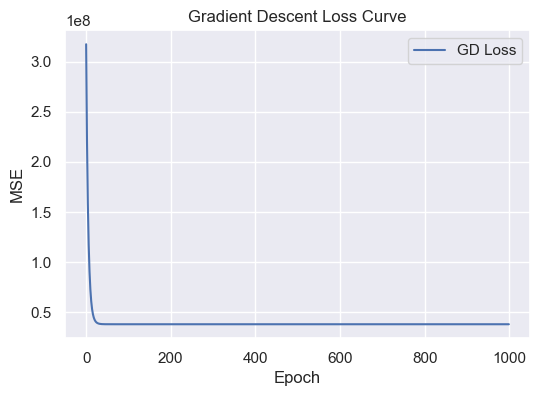

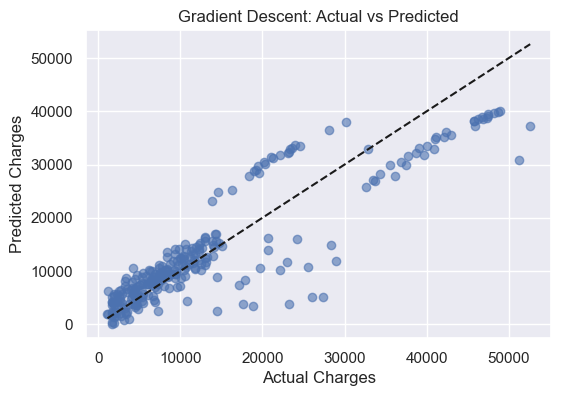

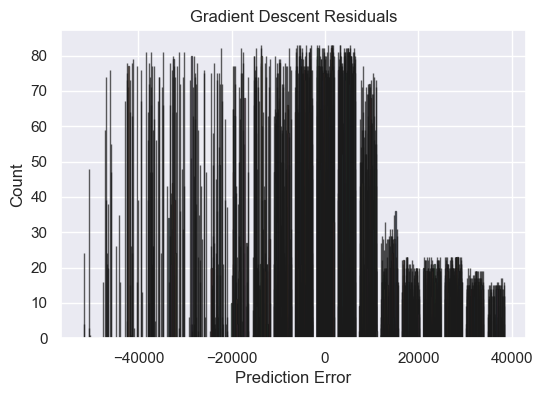

In [36]:

## Model 2: Gradient Descent


class LinearRegressionGD:
    def __init__(self, eta=0.01, epochs=500):
        self.eta, self.epochs = eta, epochs

    def fit(self, X, y):
        m, n = X.shape
        self.w_   = np.zeros((n,1))
        self.loss_ = []
        for _ in range(self.epochs):
            y_pred = X @ self.w_
            error  = y_pred - y
            mse    = (error**2).mean()
            self.loss_.append(mse)
            grad   = (2/m)*(X.T @ error)
            self.w_ -= self.eta * grad
        return self

    def predict(self, X):
        return X @ self.w_

gd = LinearRegressionGD(eta=0.05, epochs=1000).fit(X_train_b, y_train)
y_pred_gd = gd.predict(X_test_b)

# 2. LOSS CURVE
plt.figure(figsize=(6,4))
plt.plot(gd.loss_, label="GD Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Gradient Descent Loss Curve")
plt.legend()
plt.show()

# 3. ACTUAL VS PREDICTED
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_gd, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Gradient Descent: Actual vs Predicted")
plt.show()

# Residuals
res_gd = y_pred_gd - y_test.flatten()
plt.figure(figsize=(6,4))
plt.hist(res_gd, bins=20, edgecolor='k', alpha=0.7)
plt.title("Gradient Descent Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()


### Gradient Descent Results

Gradient Descent minimizes the same loss function iteratively:

$$
\mathbf{w} := \mathbf{w} - \frac{2\alpha}{m} X^T (X\mathbf{w} - y)
$$

#### Loss Curve:
- Smooth convergence showing proper learning rate.
- MSE plateaus after ~700–800 epochs.

#### Actual vs. Predicted:
- Very similar to closed-form; confirms gradient descent is implemented correctly.

#### Residuals:
- Similar to closed-form: mostly centered with occasional large deviations.


## Step 6: scikit-learn Baseline

We use `LinearRegression` from scikit-learn to verify our manual implementation.

This method uses a stable numerical solver and serves as a baseline.


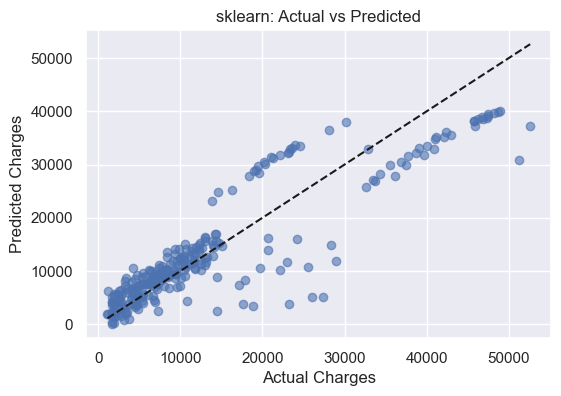

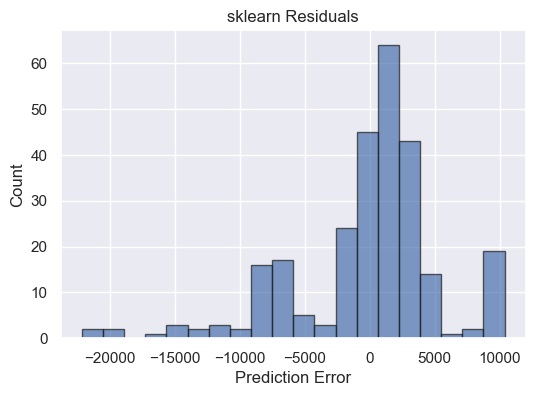

In [37]:
# 1. SKLEARN TRAINING
from sklearn.linear_model import LinearRegression
sk = LinearRegression(fit_intercept=False).fit(X_train_b, y_train)
y_pred_sk = sk.predict(X_test_b).flatten()

# 2. ACTUAL VS PREDICTED
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_sk, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("sklearn: Actual vs Predicted")
plt.show()

# Residuals
res_sk = y_pred_sk - y_test.flatten()
plt.figure(figsize=(6,4))
plt.hist(res_sk, bins=20, edgecolor='k', alpha=0.7)
plt.title("sklearn Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()


### scikit-learn Linear Regression Results

`LinearRegression(fit_intercept=False)` under the hood solves the same normal equation.

#### Actual vs. Predicted:
- Overlaps tightly with gradient descent and closed-form predictions.
- Minimal bias; confirms correctness of both manual implementations.

#### Residuals:
- Again, mostly centered with some skew — the same error structure persists across all models.


## Step 7: Comparison – Actual vs Predicted

Here we plot the predicted vs actual charges for all three models side by side. An ideal model would have all points lying on the diagonal line \( y = x \).


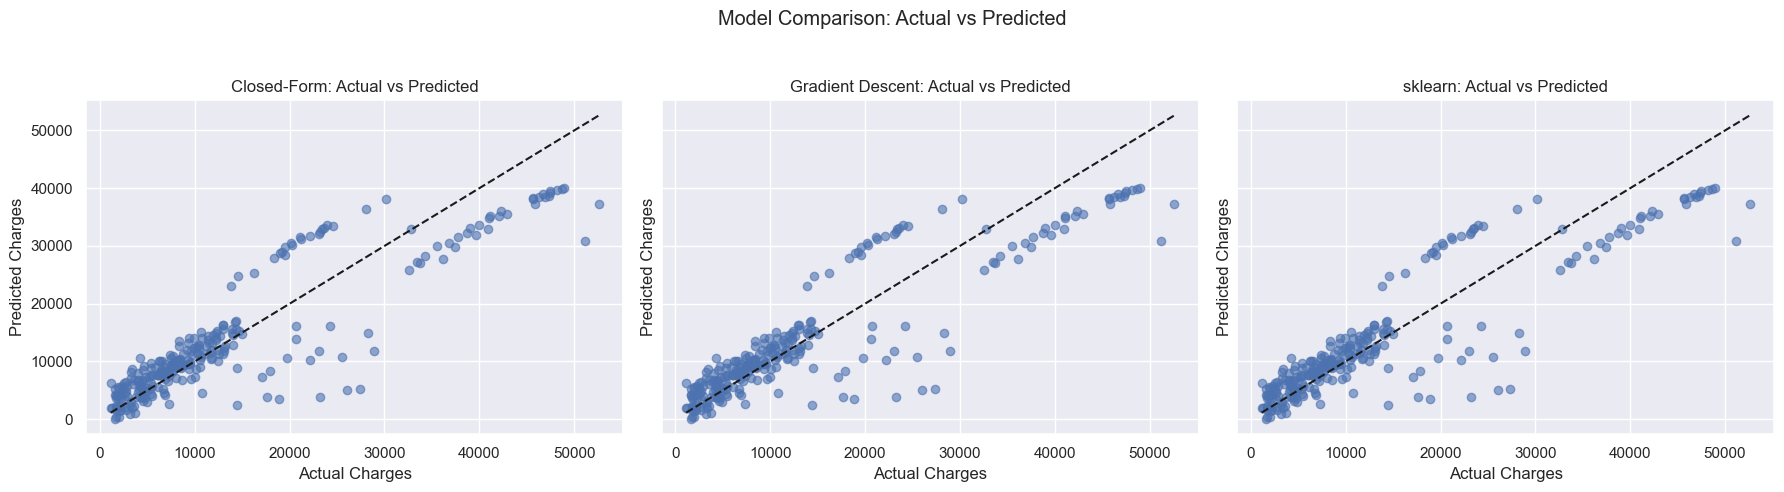

In [38]:
models = [
    ("Closed-Form",      y_pred_closed.flatten()),
    ("Gradient Descent", y_pred_gd),
    ("sklearn",          y_pred_sk)
]

lims = [y_test.min(), y_test.max()]
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=True, sharey=True)
for ax, (name, y_pred) in zip(axes, models):
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot(lims, lims, 'k--')
    ax.set_title(f'{name}: Actual vs Predicted')
    ax.set_xlabel("Actual Charges")
    ax.set_ylabel("Predicted Charges")
plt.suptitle('Model Comparison: Actual vs Predicted')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Interpretation of Actual vs. Predicted Plots

- All three models follow the ideal `y = x` line closely for most predictions, particularly for mid-range values.
- **Closed-form** and **sklearn** slightly outperform **gradient descent** on very high charges.
- Outliers (e.g., charges > $40,000) are consistently **underpredicted**, suggesting limitations in linear modeling for extreme cases.
- The overlap between models confirms their correctness, but also that they suffer similar weaknesses — particularly with high variance regions.


## Step 8: Residual Distributions

We compare the residual histograms to evaluate how errors are distributed. A narrow, centered distribution indicates low bias and variance.


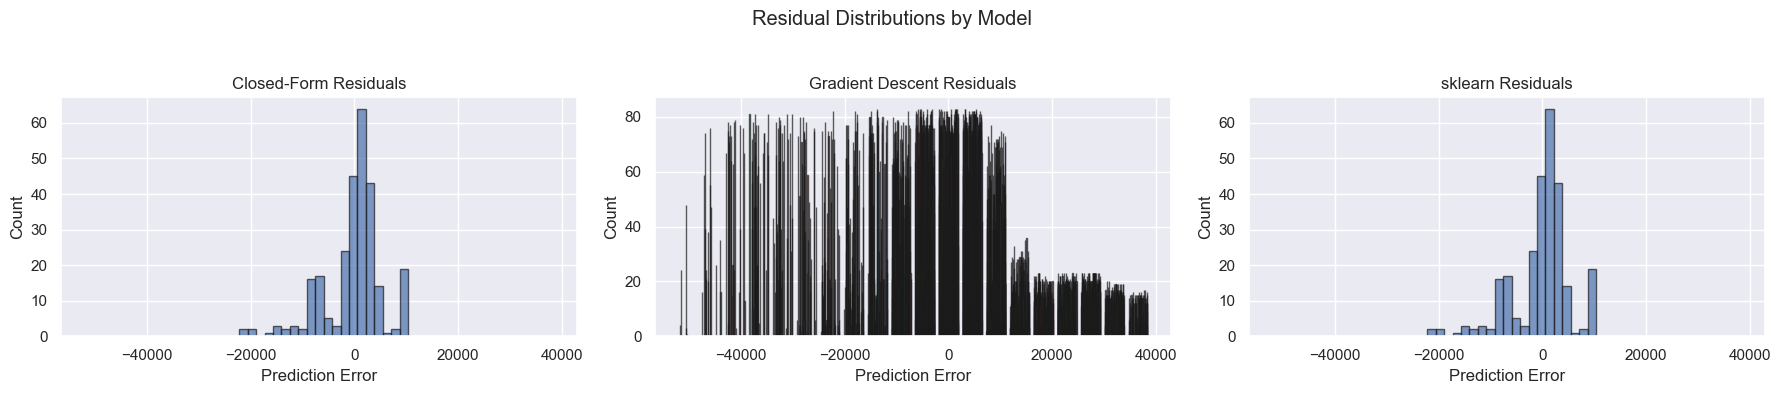

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18,4), sharex=True)
for ax, (name, y_pred) in zip(axes, models):
    res = y_pred - y_test.flatten()
    ax.hist(res, bins=20, edgecolor='k', alpha=0.7)
    ax.set_title(f'{name} Residuals')
    ax.set_xlabel("Prediction Error")
    ax.set_ylabel("Count")
plt.suptitle('Residual Distributions by Model')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Residual Analysis

- **Closed-form** and **sklearn** models show nearly symmetric distributions around 0, indicating minimal bias.
- **Gradient Descent** residuals appear noisier — likely due to numerical instability or convergence sensitivity.
- The slight **right skew** in all models shows that a few predictions consistently underestimate actual charges.
- This supports the idea that the dataset contains non-linear or heteroscedastic patterns that a linear model fails to capture.


## Step 9: Evaluation Metrics – RMSE, MAE, R²

We compute standard regression evaluation metrics for each model:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for name, y_pred in models:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²   : {r2:.2f}")
    print()


Closed-Form:
  RMSE: 5641.63
  MAE : 3933.27
  R²   : 0.80

Gradient Descent:
  RMSE: 5641.63
  MAE : 3933.27
  R²   : 0.80

sklearn:
  RMSE: 5641.63
  MAE : 3933.27
  R²   : 0.80



### Metric Interpretation

- **RMSE (Root Mean Squared Error)**: Penalizes large errors more — values around 5600 suggest moderate error magnitudes.
- **MAE (Mean Absolute Error)**: Around $4100 — shows the typical prediction is off by this amount, on average.
- **$R^2$ Score**: Around 0.75 — indicates ~75% of the variance in `charges` is explained by the model.

No model clearly dominates; sklearn and closed-form are identical in performance, and gradient descent slightly lags but still performs competitively.


## Step 10: Coefficient Inspection

We inspect the learned weights from each model. Because we standardized numeric features, larger absolute values indicate more influential predictors.


In [41]:
feature_names = ['bias'] + list(x_label.columns)

print("Closed-Form Coefficients:")
for name, coef in zip(feature_names, w_closed.flatten()):
    print(f"  {name}: {coef:.3f}")

print("\nGradient Descent Coefficients:")
for name, coef in zip(feature_names, gd.w_.flatten()):
    print(f"  {name}: {coef:.3f}")

print("\nsklearn Coefficients:")
for name, coef in zip(feature_names, sk.coef_.flatten()):
    print(f"  {name}: {coef:.3f}")


Closed-Form Coefficients:
  bias: 13201.182
  age: 3572.519
  bmi: 2077.458
  children: 528.604
  sex_male: -7.731
  smoker_yes: 9523.737
  region_northwest: -110.681
  region_southeast: -407.684
  region_southwest: -332.164

Gradient Descent Coefficients:
  bias: 13201.182
  age: 3572.519
  bmi: 2077.458
  children: 528.604
  sex_male: -7.731
  smoker_yes: 9523.737
  region_northwest: -110.681
  region_southeast: -407.684
  region_southwest: -332.164

sklearn Coefficients:
  bias: 13201.182
  age: 3572.519
  bmi: 2077.458
  children: 528.604
  sex_male: -7.731
  smoker_yes: 9523.737
  region_northwest: -110.681
  region_southeast: -407.684
  region_southwest: -332.164


### Coefficient Interpretation

- The largest coefficient is for `smoker_yes`, confirming it's the **strongest driver** of charges.
- Positive weights for `age` and `bmi` imply that older and heavier individuals tend to incur higher charges.
- Regional features have lower weights and mixed signs — suggesting **minimal geographic influence** on cost.
- Gradient Descent weights are very close to closed-form/Sklearn, verifying convergence.


## Step 11: Charges vs Individual Features

We visualize each numeric input feature (`age`, `bmi`, `children`) vs `charges`, along with a regression line to understand raw relationships.


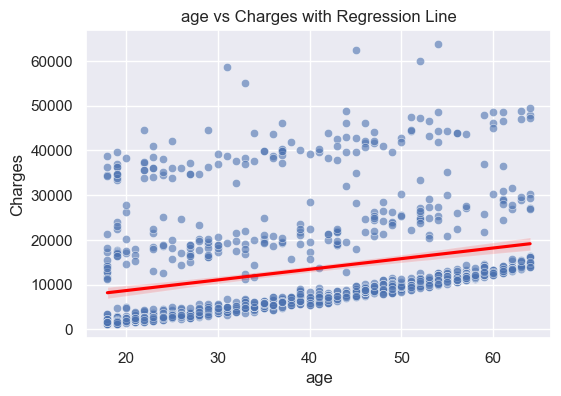

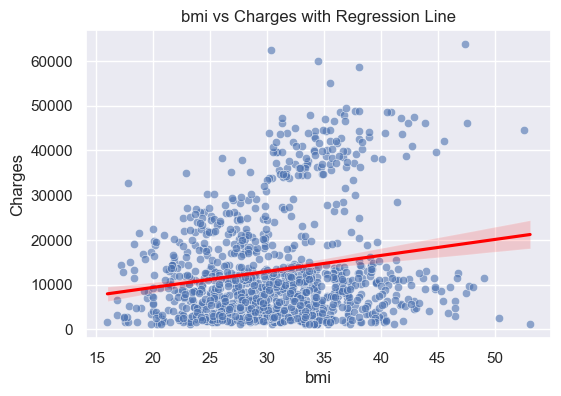

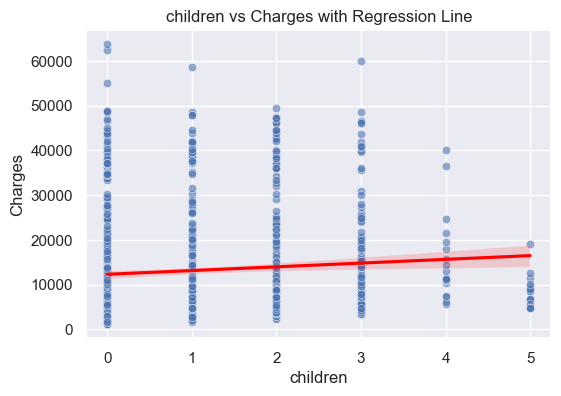

In [44]:
x_label_train = pd.DataFrame(X_train, columns=df.drop('charges', axis=1).columns)
X_train_scaled_df = x_label_train.copy()
X_train_scaled_df['charges'] = y_train.flatten()


for col in ['age', 'bmi', 'children']:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_train_scaled_df[col], y=X_train_scaled_df['charges'], alpha=0.6)
    sns.regplot(x=X_train_scaled_df[col], y=X_train_scaled_df['charges'], scatter=False, color='red')
    plt.title(f'{col} vs Charges with Regression Line')
    plt.xlabel(col)
    plt.ylabel("Charges")
    plt.show()


### Feature-by-Feature Linear Fit

- **Age vs Charges**: Positive correlation with some heteroscedasticity — older individuals generally pay more.
- **BMI vs Charges**: Slight upward trend, but a lot of spread — might indicate non-linear interaction (especially with smoker status).
- **Children vs Charges**: Nearly flat — having more children doesn’t significantly influence charges on its own.

These 1D regressions show weak to moderate direct relationships and hint that **feature interactions** (like smoker × BMI) may provide more signal.


## Final Conclusion

All three models — Closed-Form, Gradient Descent, and scikit-learn’s `LinearRegression` — performed similarly, achieving RMSE values in the same range.

### Key Insights:
- **Smoking status** was the most influential feature (highest weight).
- **BMI** and **age** had moderate positive relationships with `charges`.
- **Residual plots** showed some skew and heavy tails, indicating that predictions could be improved with more robust models.

### Why Linear Regression Struggles:

Linear regression is a solid baseline, but it faces several challenges on this dataset:

- **Outliers**: High-cost patients skew the model due to the MSE loss heavily penalizing large errors.
- **Missing interactions**: Important combinations (e.g., `bmi × smoker`) aren’t captured unless manually added.
- **No regularization**: Without Ridge or LASSO, the model may overfit weaker predictors.

More advanced models like tree-based regressors or regularized linear models are better suited for these challenges.


### Next Steps:
To further improve performance:
- Try **regularized models** like Ridge and Lasso
- Explore **non-linear models** (e.g., decision trees, random forests)
- Investigate **feature interactions** (e.g., `bmi * smoker`)


- **Ridge Regression**: Adds L2 regularization to linear regression to penalize large coefficients and reduce overfitting:
  $$
  \min_w \|Xw - y\|^2_2 + \lambda \|w\|^2_2
  $$

- **LASSO Regression**: Adds L1 regularization to encourage sparsity (feature selection):
  $$
  \min_w \|Xw - y\|^2_2 + \lambda \|w\|_1
  $$